In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/utkface-new/UTKFace/26_0_2_20170104023102422.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/22_1_1_20170112233644761.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/21_1_3_20170105003215901.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/28_0_0_20170117180555824.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/17_1_4_20170103222931966.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/44_0_3_20170119201022260.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/35_0_2_20170116182734834.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/76_0_0_20170104213515132.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/36_1_0_20170116165722892.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/34_0_3_20170119200815948.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/18_1_0_20170104022856102.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/40_1_1_20170113011948248.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/45_0_0_20170117180013541.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/26_1_1_20170117153641469.jpg.c

In [2]:
import cv2
from PIL import Image
from keras.preprocessing.image import load_img

2025-08-10 03:07:42.389656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754795262.641611      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754795262.716301      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.utils import plot_model

In [4]:
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Add, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import datasets, layers, models


In [5]:
BASE_DIRS=[r'/kaggle/input/utkface-new/UTKFace']

In [6]:
image_paths = []
age_labels =[]
gender_paths =[]

In [7]:
from tqdm import tqdm

In [8]:
for BASE_DIR in BASE_DIRS:
    for filename in tqdm(os.listdir(BASE_DIR)):
        temp=filename.split('_')
        if temp[0].isdigit():
            age=int(temp[0])
            gender=int(temp[1])
            image_path=os.path.join(BASE_DIR,filename)
            image_paths.append(image_path)
            age_labels.append(age)
            gender_paths.append(gender)

100%|██████████| 23708/23708 [00:00<00:00, 588846.80it/s]


In [9]:
print(image_paths)

['/kaggle/input/utkface-new/UTKFace/26_0_2_20170104023102422.jpg.chip.jpg', '/kaggle/input/utkface-new/UTKFace/22_1_1_20170112233644761.jpg.chip.jpg', '/kaggle/input/utkface-new/UTKFace/21_1_3_20170105003215901.jpg.chip.jpg', '/kaggle/input/utkface-new/UTKFace/28_0_0_20170117180555824.jpg.chip.jpg', '/kaggle/input/utkface-new/UTKFace/17_1_4_20170103222931966.jpg.chip.jpg', '/kaggle/input/utkface-new/UTKFace/44_0_3_20170119201022260.jpg.chip.jpg', '/kaggle/input/utkface-new/UTKFace/35_0_2_20170116182734834.jpg.chip.jpg', '/kaggle/input/utkface-new/UTKFace/76_0_0_20170104213515132.jpg.chip.jpg', '/kaggle/input/utkface-new/UTKFace/36_1_0_20170116165722892.jpg.chip.jpg', '/kaggle/input/utkface-new/UTKFace/34_0_3_20170119200815948.jpg.chip.jpg', '/kaggle/input/utkface-new/UTKFace/18_1_0_20170104022856102.jpg.chip.jpg', '/kaggle/input/utkface-new/UTKFace/40_1_1_20170113011948248.jpg.chip.jpg', '/kaggle/input/utkface-new/UTKFace/45_0_0_20170117180013541.jpg.chip.jpg', '/kaggle/input/utkface-n

In [10]:
df=pd.DataFrame()
df['image'],df['age'],df['gender']=image_paths,age_labels,gender_paths
print(df)

                                                   image  age  gender
0      /kaggle/input/utkface-new/UTKFace/26_0_2_20170...   26       0
1      /kaggle/input/utkface-new/UTKFace/22_1_1_20170...   22       1
2      /kaggle/input/utkface-new/UTKFace/21_1_3_20170...   21       1
3      /kaggle/input/utkface-new/UTKFace/28_0_0_20170...   28       0
4      /kaggle/input/utkface-new/UTKFace/17_1_4_20170...   17       1
...                                                  ...  ...     ...
23703  /kaggle/input/utkface-new/UTKFace/41_0_0_20170...   41       0
23704  /kaggle/input/utkface-new/UTKFace/42_0_0_20170...   42       0
23705  /kaggle/input/utkface-new/UTKFace/2_0_2_201612...    2       0
23706  /kaggle/input/utkface-new/UTKFace/65_1_0_20170...   65       1
23707  /kaggle/input/utkface-new/UTKFace/66_0_1_20170...   66       0

[23708 rows x 3 columns]


In [11]:
print("DataFrame shape:",df.shape)

DataFrame shape: (23708, 3)


In [12]:
gender_dict={0:'Male',1:'Female'}

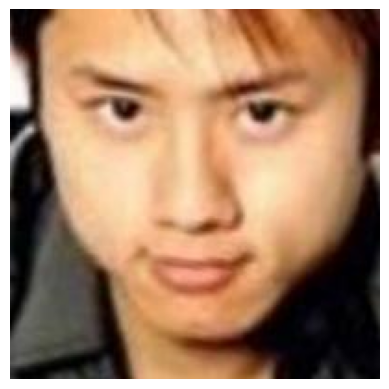

In [13]:
if not df.empty:
    try:
        img=Image.open(df['image'][0])
        plt.axis('off')
        plt.imshow(img)
        plt.show()
    except Exception as e:
        print("Error:",e)
else:
    print("No image found")

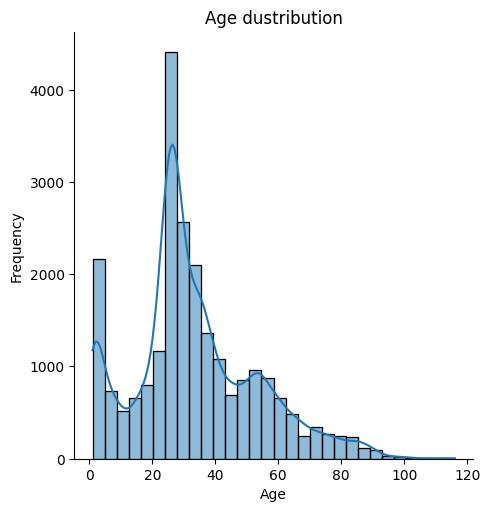

In [14]:
sns.displot(df['age'],kde=True, bins=30)
plt.title("Age dustribution")
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Feature Extraction: 
1. Standarizing image size
2. Converting into numerical array
3. Redusing computational complexcity grayscale instead of RGB
4. Reshaping the data to fit the input layer of our CNN
5. Normalizing the pixel value to improve training efficiency



In [15]:
def extract_feature(images):
    features = []
    for image_path in tqdm(images):
        img = Image.open(image_path).convert('L')  # Correct way to open image
        img = img.resize((128, 128), Image.BILINEAR)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features
        

In [16]:
x= extract_feature(df['image'])

100%|██████████| 23708/23708 [02:31<00:00, 156.68it/s]


In [17]:
x=x/255.0
y_gender=np.array(df['gender'])
y_age=np.array(df['age'])
print("Shape of y_gender", y_gender.shape)
print("Shape of y_age", y_age.shape)

Shape of y_gender (23708,)
Shape of y_age (23708,)


In [18]:
input_shape = (128, 128, 1)
inputs = Input(input_shape)

conv1 = Conv2D(32, kernel_size=(3,3), activation='relu')(inputs)
maxp1 = MaxPooling2D(pool_size=(2,2))(conv1)

conv2 = Conv2D(64, kernel_size=(3,3), activation='relu')(maxp1)
maxp2 = MaxPooling2D(pool_size=(2,2))(conv2)

conv3 = Conv2D(128, kernel_size=(3,3), activation='relu')(maxp2)
maxp3 = MaxPooling2D(pool_size=(2,2))(conv3)

conv4 = Conv2D(256, kernel_size=(3,3), activation='relu')(maxp3)
maxp4 = MaxPooling2D(pool_size=(2,2))(conv4)

flatten = Flatten()(maxp4)

dense1 = Dense(256, activation='relu')(flatten)
dropout1 = Dropout(0.3)(dense1)

dense2 = Dense(256, activation='relu')(flatten)
dropout2 = Dropout(0.3)(dense2)

output1 = Dense(1, activation='sigmoid', name='gender_out')(dropout1)
output2 = Dense(1, activation='linear', name='age_out')(dropout2)

model = Model(inputs=inputs, outputs=[output1, output2])

model.summary()

I0000 00:00:1754795430.293658      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 12,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 6, 256) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 9216)      │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  2,359,552 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │  2,359,552 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_out (Dense)  │ (None, 1)         │        257 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_out (Dense)     │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,107,458 (19.48 MB)

 Trainable params: 5,107,458 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
y_combined=np.column_stack((y_gender, y_age))
X_train, X_temp, y_combined_train, y_combined_temp= train_test_split(x,y_combined, test_size=0.2, random_state=42)
x_test, x_val, y_combined_test, y_combined_val= train_test_split(X_temp, y_combined_temp, test_size=0.2, random_state=42)


In [20]:
y_train_gender, y_train_age= y_combined_train[:,0], y_combined_train[:,1]
y_test_gender, y_test_age= y_combined_test[:,0], y_combined_test[:,1]
y_val_gender, y_val_age= y_combined_val[:,0], y_combined_val[:,1]


In [21]:
model_path= './best_model.keras'
checkpointer = ModelCheckpoint(
    filepath= model_path,
    monitor='val_gender_out_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True
)

In [22]:
from keras.callbacks import LearningRateScheduler
model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam',
              metrics=['accuracy','mae'])
annealer= LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)



In [23]:
total_images=len(image_paths)
print(f"Total number of images:{total_images}")

Total number of images:23708


In [24]:
train_images= len(X_train)
validation_images= len(x_val)
test_images= len(x_test)
print("Number of training images:", train_images)
print("Number of validation images:", validation_images)
print("Number of test images:", test_images)

Number of training images: 18966
Number of validation images: 949
Number of test images: 3793


In [25]:
# import tensorflow as tf >>already imported
tf.config.run_functions_eagerly(True)

In [26]:
history=model.fit(
    x=X_train,
    y=[y_train_gender, y_train_age],
    batch_size=128,
    epochs=45,
    validation_data=(x_val, [y_val_gender, y_val_age]),
    callbacks=[annealer, checkpointer]
)

Epoch 1/45


I0000 00:00:1754795436.532003      36 cuda_dnn.cc:529] Loaded cuDNN version 90300


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - age_out_loss: 17.8829 - age_out_mae: 17.8829 - gender_out_accuracy: 0.5227 - gender_out_loss: 0.7317 - loss: 18.6146
Epoch 1: val_gender_out_accuracy improved from -inf to 0.59536, saving model to ./best_model.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 25s 139ms/step - age_out_loss: 17.8698 - age_out_mae: 17.8698 - gender_out_accuracy: 0.5227 - gender_out_loss: 0.7315 - loss: 18.6014 - val_age_out_loss: 14.2622 - val_age_out_mae: 14.2622 - val_gender_out_accuracy: 0.5954 - val_gender_out_loss: 0.6860 - val_loss: 14.9482 - learning_rate: 0.0010
Epoch 2/45
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - age_out_loss: 14.0433 - age_out_mae: 14.0433 - gender_out_accuracy: 0.6104 - gender_out_loss: 0.6488 - loss: 14.6921
Epoch 2: val_gender_out_accuracy improved from 0.59536 to 0.73340, saving model to ./best_model.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - age_out_loss: 14.0417 - age_out_mae: 14.0417 - gender_out_accuracy: 0.6108 - gender_out_loss

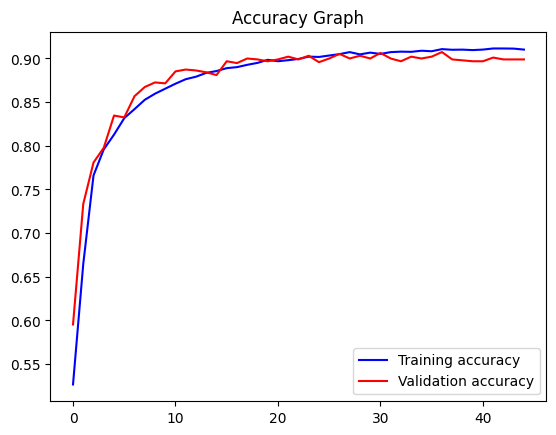

In [27]:
acc=history.history['gender_out_accuracy']
val_acc=history.history['val_gender_out_accuracy']
epochs=range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show()
   
         

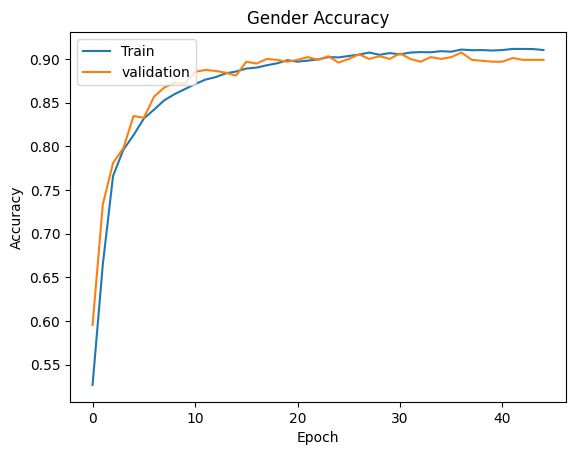

In [28]:
plt.plot(history.history['gender_out_accuracy'])
plt.plot(history.history['val_gender_out_accuracy'])
plt.title('Gender Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','validation'], loc='upper left')
plt.show()

In [29]:
image_index=3000
print(f"Gender:\t{gender_dict[y_gender[image_index]]}\t Age:\t{y_age[image_index]}")

Gender:	Male	 Age:	28


In [30]:
pred=model.predict(x[image_index].reshape(1,128,128,1))
pred_gender=gender_dict[int(round(pred[0][0][0]))]
pred_age=round(pred[1][0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Predicted gender: 	 Male	 Predicted age: 	 29


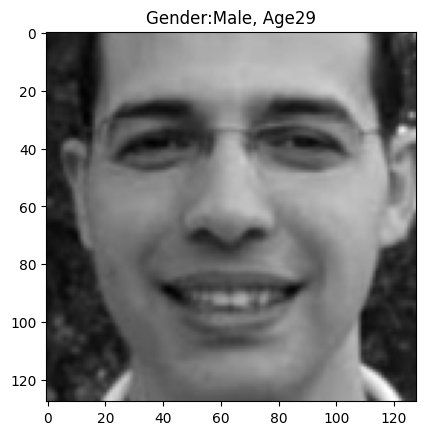

In [31]:
print(f"Predicted gender: \t {pred_gender}\t Predicted age: \t {pred_age}")
plt.title(f"Gender:{pred_gender}, Age{pred_age}")
plt.imshow(x[image_index].reshape(128,128), cmap='gray')
plt.show()



